# Libraries

In [ ]:
# Libraries
# !pip install tensorflow opencv-python numpy pandas matplotlib seaborn scikit-learn

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime


TensorFlow Version: 2.19.0


# Dataset Download & Visualization

Download the private dataset using below link

https://www.kaggle.com/datasets/msambare/fer2013?resource=download

> Dataset will be placed in directory dataset > {paste here}


Train set: (Total images: 28709)
  Angry: 3995 images
  Disgust: 436 images
  Fear: 4097 images
  Happy: 7215 images
  Neutral: 4965 images
  Sad: 4830 images
  Surprise: 3171 images

Test set: (Total images: 7178)
  Angry: 958 images
  Disgust: 111 images
  Fear: 1024 images
  Happy: 1774 images
  Neutral: 1233 images
  Sad: 1247 images
  Surprise: 831 images


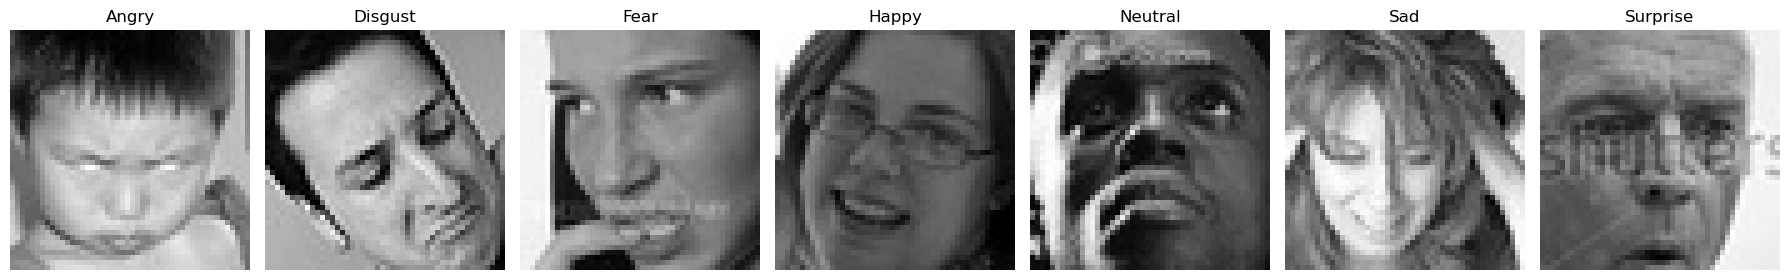

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Emotion labels in FER2013 dataset
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# dataset root path
dataset_root = "./dataset"

# Count images
def count_images(directory):
    counts = {}
    for emotion in emotions:
        emotion_dir = os.path.join(directory, emotion)
        if os.path.exists(emotion_dir):
            counts[emotion] = len(os.listdir(emotion_dir))
        else:
            counts[emotion] = 0
    return counts

# Print counts for train and test images
for folder in ["train", "test"]:
    folder_path = os.path.join(dataset_root, folder)
    counts = count_images(folder_path)
    print(f"\n{folder.capitalize()} set: (Total images: {sum(counts.values())})")
    for emotion in emotions:
        print(f"  {emotion.capitalize()}: {counts[emotion]} images")

# Grid View plotting function
def visualize_grid(directory):
    plt.figure(figsize=(18, 4))
    for idx, emotion in enumerate(emotions):
        class_dir = os.path.join(directory, emotion)
        img_names = os.listdir(class_dir)
        if not img_names:
            continue
        img_path = os.path.join(class_dir, img_names[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(1, len(emotions), idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(emotion.capitalize())
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize from train set
visualize_grid(os.path.join(dataset_root, "train"))


## Data Preprocessing

In [ ]:
# Preprocessing function
def preprocess_image(img):
    # Convert grayscale to RGB by replicating channels
    if len(img.shape) == 2 or img.shape[-1] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Resize to 224x224
    img = cv2.resize(img, (224, 224))
    # Normalize using MobileNetV2's preprocess_input
    img = preprocess_input(img)
    return img

# Test preprocessing on a sample image
sample_img_path = os.path.join(dataset_root, "train", "happy", os.listdir(os.path.join(dataset_root, "train", "happy"))[0])
sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
processed_img = preprocess_image(sample_img)
print(f"Processed image shape: {processed_img.shape}")
print(f"Pixel value range: [{processed_img.min()}, {processed_img.max()}]")


Processed image shape: (224, 224, 3)
Pixel value range: [-1.0, 1.0]


# Create Train/Validate/Test Generators

In [ ]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 64

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.3  # 70/30 split
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    validation_split=0.3
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_root, "train"),
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    classes=emotions,
    subset="training",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_root, "train"),
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    classes=emotions,
    subset="validation",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_root, "test"),
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    classes=emotions,
    shuffle=False
)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# Map class indices to emotion labels
class_indices = train_generator.class_indices  # e.g., {'angry': 0, 'disgust': 1, ...}
index_to_emotion = {v: k for k, v in class_indices.items()}  # e.g., {0: 'angry', 1: 'disgust', ...}

# Print class weights with emotion labels
print("Class Weights:")
for idx, weight in class_weights_dict.items():
    emotion = index_to_emotion[idx]
    print(f"  {emotion.capitalize():<10}: {weight:.4f}")


Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights:
  Angry     : 1.0266
  Disgust   : 9.3833
  Fear      : 1.0011
  Happy     : 0.5685
  Neutral   : 0.8260
  Sad       : 0.8492
  Surprise  : 1.2934


## MobileNetv2 Model

In [ ]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = Dense(128, activation="relu")(x)  # First dense layer
x = Dense(64, activation="relu")(x)   # Additional dense layer
x = Dropout(0.5)(x)                   # Dropout to prevent overfitting
predictions = Dense(7, activation="softmax")(x)  # Output layer for 7 emotions

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,430,663 (9.27 MB)

 Trainable params: 172,679 (674.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training the Model

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("new_best_emotion_model.h5", monitor="val_accuracy", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6)
]

# Train model
history = model.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curves")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

Epoch 1/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2554 - loss: 1.8825

315/315 ━━━━━━━━━━━━━━━━━━━━ 865s 3s/step - accuracy: 0.2554 - loss: 1.8823 - val_accuracy: 0.3317 - val_loss: 1.7569 - learning_rate: 1.0000e-04
Epoch 2/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2815 - loss: 1.7830

315/315 ━━━━━━━━━━━━━━━━━━━━ 673s 2s/step - accuracy: 0.2815 - loss: 1.7830 - val_accuracy: 0.3329 - val_loss: 1.7342 - learning_rate: 1.0000e-04
Epoch 3/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3060 - loss: 1.7645

315/315 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.3060 - loss: 1.7645 - val_accuracy: 0.3516 - val_loss: 1.7229 - learning_rate: 1.0000e-04
Epoch 4/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.3170 - loss: 1.7537 - val_accuracy: 0.3465 - val_loss: 1.7045 - learning_rate: 1.0000e-04
Epoch 5/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3197 - loss: 1.7135

315/315 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.3198 - loss: 1.7134 - val_accuracy: 0.3683 - val_loss: 1.6755 - learning_rate: 1.0000e-04
Epoch 6/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3328 - loss: 1.7156

315/315 ━━━━━━━━━━━━━━━━━━━━ 794s 3s/step - accuracy: 0.3328 - loss: 1.7155 - val_accuracy: 0.3872 - val_loss: 1.6340 - learning_rate: 1.0000e-04
Epoch 7/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.3371 - loss: 1.6925 - val_accuracy: 0.3869 - val_loss: 1.6340 - learning_rate: 1.0000e-04
Epoch 8/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3409 - loss: 1.6752

315/315 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.3409 - loss: 1.6752 - val_accuracy: 0.3967 - val_loss: 1.6146 - learning_rate: 1.0000e-04
Epoch 9/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3499 - loss: 1.6623

315/315 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - accuracy: 0.3499 - loss: 1.6622 - val_accuracy: 0.4107 - val_loss: 1.5718 - learning_rate: 1.0000e-04
Epoch 10/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 893s 3s/step - accuracy: 0.3547 - loss: 1.6328 - val_accuracy: 0.3952 - val_loss: 1.6005 - learning_rate: 1.0000e-04
Epoch 11/12
315/315 ━━━━━━━━━━━━━━━━━━━━ 813s 3s/step - accuracy: 0.3589 - loss: 1.6178 - val_accuracy: 0.4105 - val_loss: 1.5639 - learning_rate: 1.0000e-04
Epoch 12/12
 70/315 ━━━━━━━━━━━━━━━━━━━━ 7:04 2s/step - accuracy: 0.3450 - loss: 1.7359

# Evaluation

In [ ]:
# Load best model
model = load_model("new_best_emotion_model.h5")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=emotions))


# Main (Webcam Inference)

In [ ]:
# Opens webcam window showing real-time face detection with emotion labels
# Saves emotion logs as CSV files in ./logs/
# Closes on pressing 'q'

# Load model and Haar Cascade
model = load_model("new_best_emotion_model.h5")
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
if face_cascade.empty():
    raise Exception("Error loading Haar Cascade")

# Initialize webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise Exception("Error opening webcam")

# Initialize log
log_data = {"timestamp": [], "emotion": [], "confidence": []}
os.makedirs("logs", exist_ok=True)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame")
            break

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            # Extract and preprocess face
            face = frame[y:y+h, x:x+w]
            face_processed = preprocess_image(face)
            face_array = np.expand_dims(face_processed, axis=0)

            # Predict emotion
            pred = model.predict(face_array, verbose=0)
            emotion_idx = np.argmax(pred[0])
            emotion = emotions[emotion_idx]
            confidence = pred[0][emotion_idx]

            # Draw bounding box and label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            label = f"{emotion}: {confidence:.2f}"
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            # Log emotion
            log_data["timestamp"].append(datetime.now())
            log_data["emotion"].append(emotion)
            log_data["confidence"].append(float(confidence))

        # Display frame
        cv2.imshow("EmoTrack - Real-Time Emotion Detection", frame)

        # Save log periodically
        if len(log_data["timestamp"]) >= 100:
            df = pd.DataFrame(log_data)
            df.to_csv(f"logs/emotion_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)
            log_data = {"timestamp": [], "emotion": [], "confidence": []}

        # Exit on 'q'
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

finally:
    # Save remaining log
    if log_data["timestamp"]:
        df = pd.DataFrame(log_data)
        df.to_csv(f"logs/emotion_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)
    
    # Cleanup
    cap.release()
    cv2.destroyAllWindows()


# Emotion Logging and Summary Charts

In [ ]:
# bar plot of emotion frequency
# counts of each emotion (e.g., happy: 50, sad: 30, etc.)

# Load latest log file
log_files = [f for f in os.listdir("logs") if f.startswith("emotion_log")]
if log_files:
    latest_log = max(log_files, key=lambda x: os.path.getctime(os.path.join("logs", x)))
    df = pd.read_csv(os.path.join("logs", latest_log))
    
    # Plot emotion frequency
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x="emotion", order=emotions)
    plt.title("Emotion Frequency")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.show()
    
    # Print summary
    print("Emotion Counts:")
    print(df["emotion"].value_counts())
else:
    print("No log files found")
